# Download the Data

In [1]:
import pandas as pd

df = pd.read_csv("data/insurance.csv")

In [2]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


- bmi = Body mass index
- charges: Individual medical costs billed by health insurance

In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


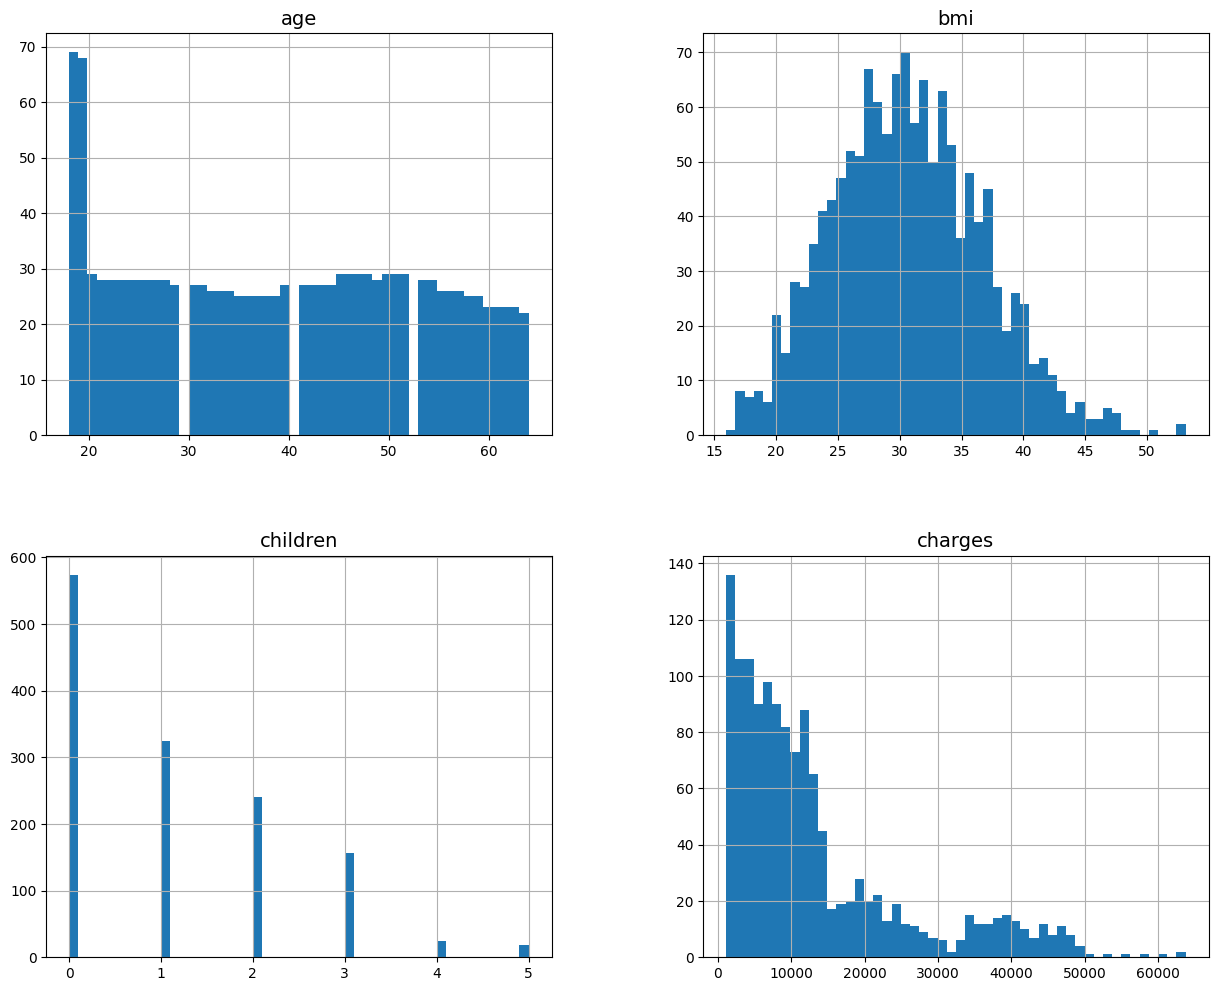

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(15,12))
plt.show()

# Create a Test Set

In [6]:
import numpy as np

df["charges_cat"] = pd.cut(df["charges"],
                               bins = [1120, 4740, 9382, 16639, 30000, np.inf],
                               labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High'])

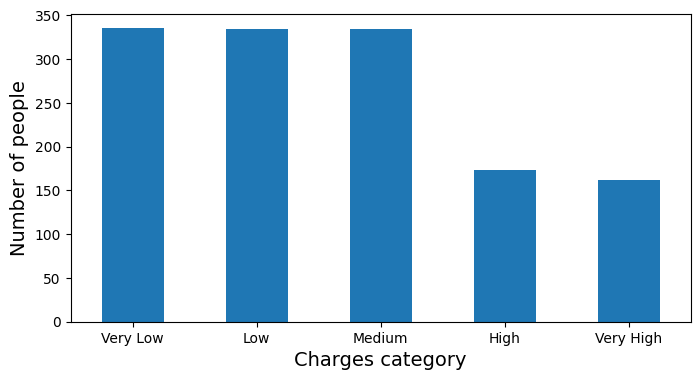

In [7]:
plt.figure(figsize=(8, 4))

df["charges_cat"].value_counts().sort_index().plot.bar(rot=0, grid=False)
plt.xlabel("Charges category")
plt.ylabel("Number of people")

plt.show()

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, stratify=df['charges_cat'], test_size=0.2, random_state=42)

In [9]:
def income_cat_proportions(data):
    return data["charges_cat"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(df),
    "Stratified %": income_cat_proportions(test_set),
}).sort_index()

(compare_props * 100).round(2)

,Overall %,Stratified %
charges_cat,,
Very Low,25.04,25.00
Low,24.96,25.00
Medium,24.96,25.00
High,12.93,13.06
Very High,12.11,11.94


In [10]:
for set_ in (train_set, test_set):
    set_.drop("charges_cat", axis=1, inplace=True)

# Discover and Visualize the Data

In [11]:
insurance = train_set.copy()

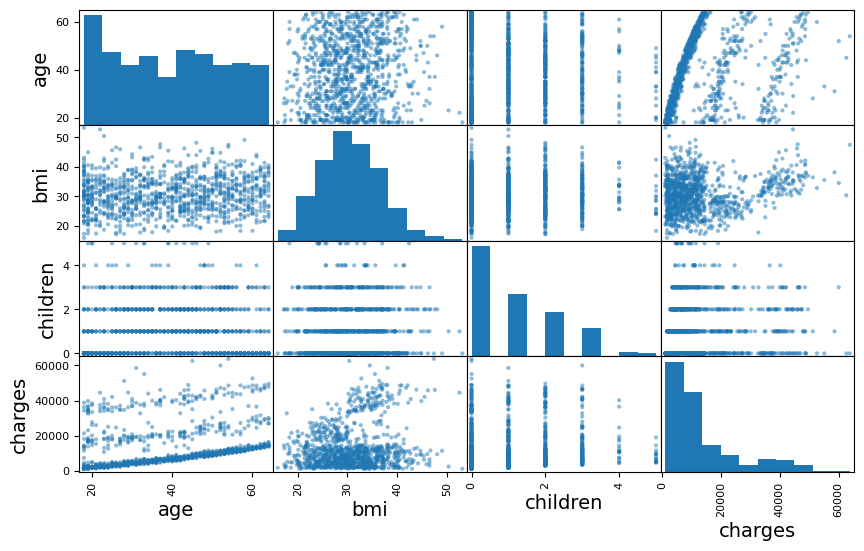

In [12]:
from pandas.plotting import scatter_matrix

numerical_columns = insurance.select_dtypes(include=['int64', 'float']).columns
scatter_matrix(insurance[numerical_columns], figsize=(10, 6))

plt.show()

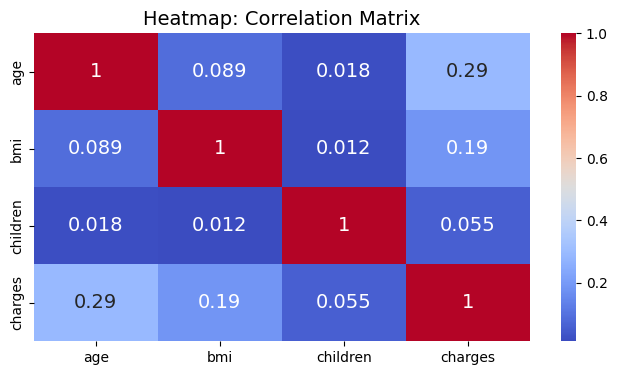

In [13]:
import seaborn as sns

correlation_matrix = insurance[numerical_columns].corr()

plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap: Correlation Matrix')
plt.show()

# Prepare the Data

In [14]:
insurance = train_set.drop("charges", axis=1)
insurance_label = train_set["charges"].copy()

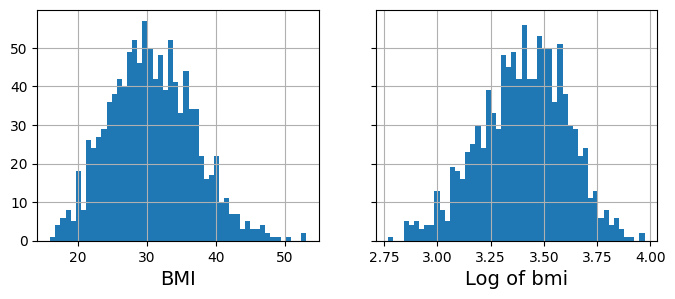

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
insurance["bmi"].hist(ax=axs[0], bins=50)
insurance["bmi"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("BMI")
axs[1].set_xlabel("Log of bmi")

plt.show()

In [16]:
insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [17]:
insurance['region'].value_counts()

region
southeast    294
northeast    260
southwest    259
northwest    257
Name: count, dtype: int64

## Transformation Pipeline

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

cat_attribs = ['sex', 'smoker', 'region']

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder())

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

log_pipeline = make_pipeline(
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

preprocessing = ColumnTransformer([
        ("log", log_pipeline, ["age", "bmi"]),
        ("cat", cat_pipeline, cat_attribs),
    ], remainder='passthrough')

In [20]:
insurance_prepared = preprocessing.fit_transform(insurance)
insurance_prepared.shape

(1070, 11)

In [21]:
insurance.shape

(1070, 6)

In [22]:
preprocessing.get_feature_names_out()

array(['log__age', 'log__bmi', 'cat__sex_female', 'cat__sex_male',
       'cat__smoker_no', 'cat__smoker_yes', 'cat__region_northeast',
       'cat__region_northwest', 'cat__region_southeast',
       'cat__region_southwest', 'remainder__children'], dtype=object)

# Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())

In [24]:
from sklearn.model_selection import cross_val_score

lin_rmses = -cross_val_score(lin_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(lin_rmses).describe()

count      10.000000
mean     6145.983728
std       683.714780
min      5243.014235
25%      5594.074208
50%      6106.548224
75%      6568.160699
max      7280.824471
dtype: float64

In [25]:
relative_rmse_lin_reg = lin_rmses.mean() / insurance_label.mean()
relative_rmse_lin_reg.round(2)

0.46

In [26]:
lin_reg.fit(insurance, insurance_label)
y_pred = lin_reg.predict(insurance)

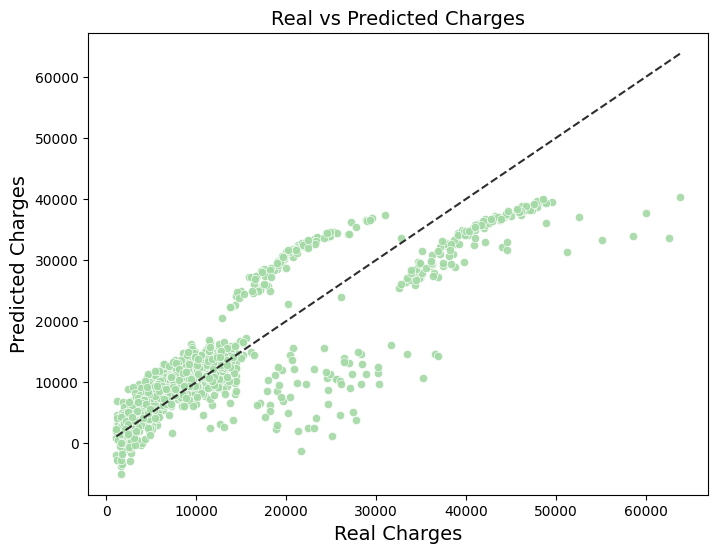

In [27]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred, color='#A3D9A5', alpha=0.9)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')
plt.xlabel('Real Charges')
plt.ylabel('Predicted Charges')
plt.title('Real vs Predicted Charges')
plt.show()

In [28]:
lin_reg.named_steps['linearregression'].intercept_

20033.553344005737

In [55]:
feature_names = preprocessing.get_feature_names_out()
coef = lin_reg.named_steps['linearregression'].coef_

coef_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

coef_table['Abs_Coefficient'] = coef_table['Coefficient'].abs()
coef_table = coef_table.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

coef_table

,Feature,Coefficient,Abs_Coefficient
0,cat__smoker_yes,12029.486423,12029.486423
1,cat__smoker_no,-12029.486423,12029.486423
2,log__age,3614.268850,3614.268850
3,log__bmi,2151.880681,2151.880681
4,cat__region_northeast,497.393200,497.393200
5,cat__region_southeast,-382.720109,382.720109
6,cat__region_southwest,-345.606797,345.606797
7,remainder__children,256.420522,256.420522
8,cat__region_northwest,230.933706,230.933706
9,cat__sex_female,157.123557,157.123557


In [30]:
from sklearn.linear_model import SGDRegressor

sgd_reg = make_pipeline(preprocessing, SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)) # penalty=None means no regularization, as we want a linear model. Scikit Learn uses l2 regularization by default.

In [31]:
from sklearn.model_selection import cross_val_score

sgd_rmses = -cross_val_score(sgd_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(sgd_rmses).describe()

count      10.000000
mean     6147.248688
std       683.220228
min      5243.689535
25%      5597.801582
50%      6109.252606
75%      6573.330795
max      7281.980784
dtype: float64

In [32]:
relative_rmse_sgd_lin = lin_rmses.mean() / insurance_label.mean()
relative_rmse_sgd_lin.round(2)

0.46

# Polynomial Regression

In [33]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = make_pipeline(preprocessing, PolynomialFeatures(degree=2, include_bias=False), LinearRegression())

In [34]:
poly_rmses = -cross_val_score(poly_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(poly_rmses).describe()

count      10.000000
mean     4927.039340
std       570.303921
min      4172.729628
25%      4524.334474
50%      4806.446387
75%      5441.963294
max      5667.836687
dtype: float64

In [35]:
relative_rmse_poly_reg = poly_rmses.mean() / insurance_label.mean()
relative_rmse_poly_reg.round(2)

0.37

In [37]:
poly_reg.fit(insurance, insurance_label)
y_pred_poly = poly_reg.predict(insurance)

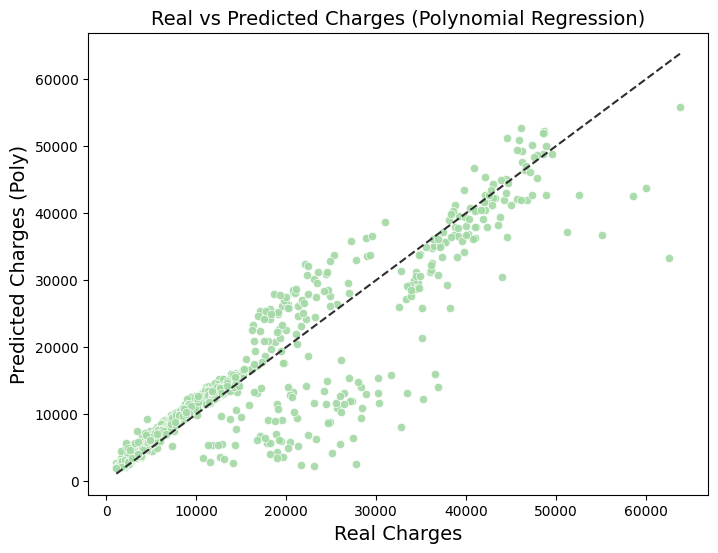

In [40]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred_poly, color='#A3D9A5', alpha=0.9)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')

plt.xlabel('Real Charges')
plt.ylabel('Predicted Charges (Poly)')
plt.title('Real vs Predicted Charges (Polynomial Regression)')
plt.show()

In [46]:
poly_reg_3 = make_pipeline(preprocessing, PolynomialFeatures(degree=3, include_bias=False), LinearRegression())

poly_rmses_3 = -cross_val_score(poly_reg_3, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

poly_rmses_3.mean()


5129.089469006457

In [52]:
feature_names = poly_reg.named_steps['polynomialfeatures'].get_feature_names_out(preprocessing.get_feature_names_out())
coef = poly_reg.named_steps['linearregression'].coef_

coef_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

coef_table['Abs_Coefficient'] = coef_table['Coefficient'].abs()
coef_table = coef_table.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

coef_table

,Feature,Coefficient,Abs_Coefficient
0,log__bmi cat__smoker_yes,5499.292078,5499.292078
1,cat__smoker_no,-4460.342887,4460.342887
2,cat__smoker_yes^2,4460.342887,4460.342887
3,cat__smoker_no^2,-4460.342887,4460.342887
4,cat__smoker_yes,4460.342887,4460.342887
...,...,...,...
72,cat__region_northeast cat__region_northwest,0.000000,0.000000
73,cat__region_northwest cat__region_southeast,0.000000,0.000000
74,cat__region_northwest cat__region_southwest,0.000000,0.000000
75,cat__region_southeast cat__region_southwest,0.000000,0.000000


Interpretation of the coefficients:
1. If a person is a smoker, the effect of BMI significantly amplifies the insurance costs.
2. Not beeing a smoker, significatly reduces insurance costs.
3. The impact of beeing a smoker increases in a nonlinear way (curve instead of a straight line) 

# Regularized Linear Models

## Ridge Regression

In [56]:
from sklearn.linear_model import Ridge

ridge_reg = make_pipeline(preprocessing, Ridge(alpha=0.1, solver="cholesky"))

In [57]:
ridge_rmses = -cross_val_score(ridge_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(ridge_rmses).describe()

count      10.000000
mean     6145.974257
std       683.554345
min      5243.192405
25%      5593.704769
50%      6107.146961
75%      6567.598642
max      7280.622458
dtype: float64

In [58]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'ridge__alpha': np.logspace(-3, 3, 100)
}

random_search = RandomizedSearchCV(
    ridge_reg, param_distributions=param_dist, 
    n_iter=10,  
    scoring='neg_root_mean_squared_error',  
    cv=5,  
    n_jobs=-1, 
    random_state=42
)

random_search.fit(insurance, insurance_label)

/Users/gonzalocaro/Desktop/Empresas - Trabajos/IUMA/Python/Practicas-ML-NN/PracticasIUMA/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'bmi']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer...
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [59]:
ridge_reg = random_search.best_estimator_

ridge_rmses = -cross_val_score(ridge_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(ridge_rmses).describe()

count      10.000000
mean     6146.032368
std       681.151244
min      5246.138384
25%      5588.298464
50%      6116.450882
75%      6559.298269
max      7277.725559
dtype: float64

In [69]:
relative_rmse_ridge_reg = ridge_rmses.mean() / insurance_label.mean()
relative_rmse_ridge_reg.round(2)

0.46

In [61]:
ridge_reg.fit(insurance, insurance_label)
y_pred_ridge = ridge_reg.predict(insurance)

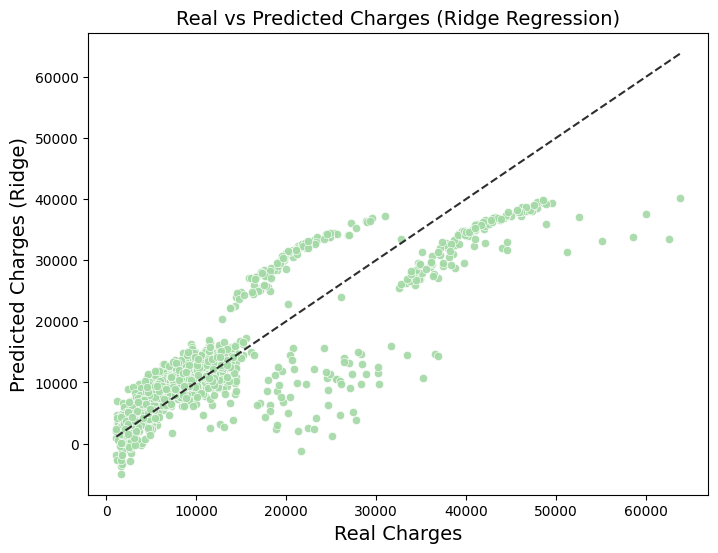

In [63]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred_ridge, color='#A3D9A5', alpha=0.9)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')

plt.xlabel('Real Charges')
plt.ylabel('Predicted Charges (Ridge)')
plt.title('Real vs Predicted Charges (Ridge Regression)')
plt.show()

In [64]:
feature_names = preprocessing.get_feature_names_out()
coef = ridge_reg.named_steps['ridge'].coef_

coef_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

coef_table['Abs_Coefficient'] = coef_table['Coefficient'].abs()
coef_table = coef_table.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

coef_table

,Feature,Coefficient,Abs_Coefficient
0,cat__smoker_yes,11972.991510,11972.991510
1,cat__smoker_no,-11972.991510,11972.991510
2,log__age,3607.476734,3607.476734
3,log__bmi,2146.938798,2146.938798
4,cat__region_northeast,493.058477,493.058477
5,cat__region_southeast,-373.383596,373.383596
6,cat__region_southwest,-346.162675,346.162675
7,remainder__children,257.094645,257.094645
8,cat__region_northwest,226.487793,226.487793
9,cat__sex_female,154.854860,154.854860


Under the ridge regression, we regularized by forcing the algorithm to keep the model weights smaller, and not only fitting the data.

In [67]:
from sklearn.linear_model import SGDRegressor

m = len(insurance)

sgd_ridge_reg = make_pipeline(preprocessing, 
                    SGDRegressor(penalty="l2", alpha=1.63 / m, tol=None,
                    max_iter=1000, eta0=0.01, random_state=42)) # penalty="l2" means Ridge Regularization (Ridge Regression), alpha is divided by "m" to get the same result as Ridge Regression.

In [68]:
sgd_ridge_rmses = -cross_val_score(sgd_ridge_reg, insurance, insurance_label,
                                   scoring="neg_root_mean_squared_error", cv=10)

pd.Series(sgd_ridge_rmses).describe()

count      10.000000
mean     6146.179826
std       681.915655
min      5243.623259
25%      5587.618222
50%      6116.414169
75%      6561.030144
max      7276.731622
dtype: float64

## Lasso Regression

In [72]:
from sklearn.linear_model import Lasso

lasso_reg = make_pipeline(preprocessing, Lasso())

In [73]:
param_dist = {
    'lasso__alpha': np.logspace(-3, 3, 100)
}

random_search = RandomizedSearchCV(
    lasso_reg, param_distributions=param_dist, 
    n_iter=10,  
    scoring='neg_root_mean_squared_error',  
    cv=5,  
    n_jobs=-1, 
    random_state=42
)

random_search.fit(insurance, insurance_label)

/Users/gonzalocaro/Desktop/Empresas - Trabajos/IUMA/Python/Practicas-ML-NN/PracticasIUMA/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'bmi']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer...
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [75]:
-random_search.best_score_

6149.116038071801

In [76]:
lasso_reg = random_search.best_estimator_

In [77]:
relative_rmse_lasso_reg = -random_search.best_score_.mean() / insurance_label.mean()
relative_rmse_lasso_reg.round(2)

0.46

# Support Vector Machines

## SVM Linear Regression

In [86]:
from sklearn.svm import LinearSVR

svm_reg = make_pipeline(preprocessing,
                        LinearSVR(epsilon=0.5, dual=True, random_state=42))

In [87]:
svm_rmses = -cross_val_score(svm_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(svm_rmses).describe()

count       10.000000
mean     15977.145113
std       1418.247362
min      12903.605849
25%      15486.929659
50%      16567.135492
75%      16994.869698
max      17236.025125
dtype: float64

In [90]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'linearsvr__epsilon': [0.01, 0.1, 0.5, 1],  
    'linearsvr__C': [0.1, 1, 10, 100],  
}

grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(insurance, insurance_label)

/Users/gonzalocaro/Desktop/Empresas - Trabajos/IUMA/Python/Practicas-ML-NN/PracticasIUMA/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('log',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log'>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'bmi']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('linearsvr',
                                        LinearSVR(dual=True, epsilon=0.5,
                                                  random_state=42))]),
             param_grid={'linearsvr__C': [0.1, 1, 10, 100],
                         'linearsvr__epsilon': [0.01, 0.1, 0.5, 1]},
             scoring='neg_root_mean_squared_error')

In [92]:
-grid_search.best_score_

8229.634507799481

In [93]:
svm_reg = grid_search.best_estimator_

relative_rmse_svm_reg = -grid_search.best_score_.mean() / insurance_label.mean()
relative_rmse_svm_reg.round(2)

0.62

In [94]:
svm_reg.fit(insurance, insurance_label)
y_pred_svm = svm_reg.predict(insurance)

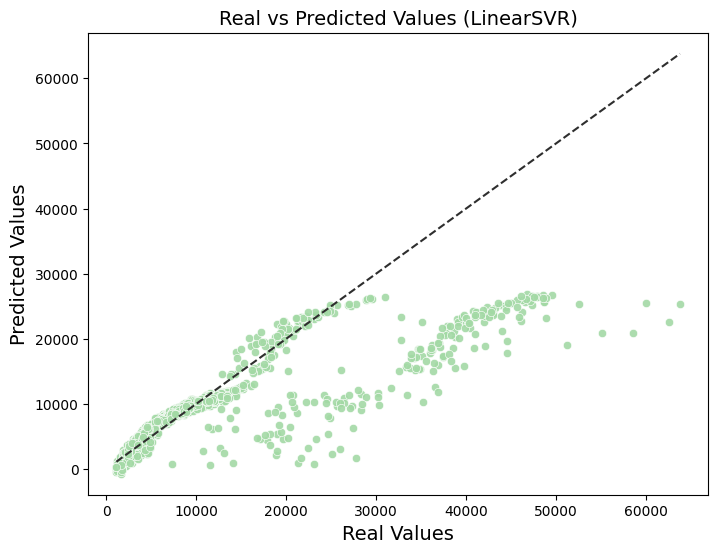

In [96]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred_svm, color='#A3D9A5', alpha=0.9)

# Línea de referencia (identidad, es decir, donde Predicho = Real)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')

# Etiquetas y título
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs Predicted Values (LinearSVR)')
plt.show()

In [97]:
feature_names = preprocessing.get_feature_names_out()
coef = svm_reg.named_steps['linearsvr'].coef_

coef_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

coef_table['Abs_Coefficient'] = coef_table['Coefficient'].abs()
coef_table = coef_table.sort_values(by='Abs_Coefficient', ascending=False).reset_index(drop=True)

coef_table

,Feature,Coefficient,Abs_Coefficient
0,cat__smoker_yes,10298.297784,10298.297784
1,cat__smoker_no,-4119.947776,4119.947776
2,log__age,3404.934573,3404.934573
3,cat__sex_female,3236.051230,3236.051230
4,cat__sex_male,2942.298778,2942.298778
5,cat__region_northeast,1812.912849,1812.912849
6,cat__region_northwest,1772.541897,1772.541897
7,cat__region_southwest,1303.763423,1303.763423
8,cat__region_southeast,1289.131839,1289.131839
9,log__bmi,421.084909,421.084909


## SVM Non Linear Regression 

In [98]:
from sklearn.svm import SVR

svm_poly_reg = make_pipeline(preprocessing,
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))

In [99]:
svm_poly_rmses = -cross_val_score(svm_poly_reg, insurance, insurance_label,
                                scoring="neg_root_mean_squared_error", cv=10)

pd.Series(svm_poly_rmses).describe()

count       10.000000
mean     12739.717753
std       1175.577238
min      10315.100585
25%      12321.149990
50%      13131.576798
75%      13661.985475
max      13755.820111
dtype: float64

In [100]:
param_dist = {
    'svr__C': [0.1, 1, 10, 100], # how much to penalize the margin error. The lower the value, the more regularization
    'svr__epsilon': np.linspace(0.01, 1, 100), # how wide the margin is 
    'svr__degree': [2, 3, 4, 5], # degree of the polynomial kernel
}

random_search = RandomizedSearchCV(
    svm_poly_reg, param_distributions=param_dist, 
    n_iter=10,  
    scoring='neg_root_mean_squared_error',  
    cv=5,  
    n_jobs=-1, 
    random_state=42
)

random_search.fit(insurance, insurance_label)

/Users/gonzalocaro/Desktop/Empresas - Trabajos/IUMA/Python/Practicas-ML-NN/PracticasIUMA/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'bmi']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer...
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [102]:
-random_search.best_score_

11141.098946978262

In [103]:
svm_poly_reg = random_search.best_estimator_

relative_rmse_svm_poly_reg = -random_search.best_score_.mean() / insurance_label.mean()
relative_rmse_svm_poly_reg.round(2)

0.84

In [104]:
svm_poly_reg.fit(insurance, insurance_label)
y_pred_svm_poly = svm_poly_reg.predict(insurance)

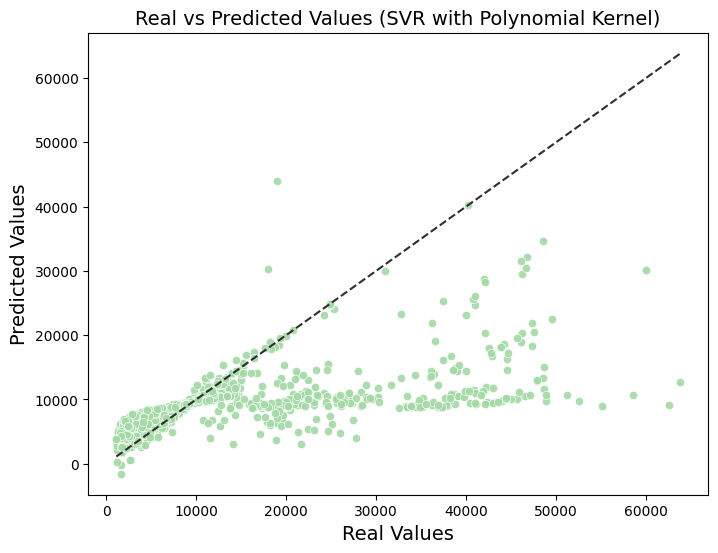

In [106]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred_svm_poly, color='#A3D9A5', alpha=0.9)

# Línea de identidad (donde predicho = real)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')

plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs Predicted Values (SVR with Polynomial Kernel)')
plt.show()

# Decision Trees